## Series temporales a los tópicos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from utils import cargar_dataset, agrupar, generar_random_walk, generar_ruido_blanco

In [2]:
# 1. Cargar datos
df = cargar_dataset(acotar=True)

df.head()

,id,timestamp,provincia,titulo,sentimiento,Hostelería y Turismo,Sanitario y Salud,Educación y Formación,Tecnología y Telecomunicaciones,Construcción e Inmobiliaria,...,Administración y Finanzas,"Cultura, Arte y Ocio",topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
0,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Asturias,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.041404,0.120992,0.041573,0.059019,0.030701,...,0.324229,0.019733,0.026325,0.026326,0.814183,0.026330,0.027860,0.026326,0.026325,0.026325
1,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Huesca,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,0,0.030990,0.057478,0.036322,0.029180,0.147316,...,0.018703,0.017910,0.009713,0.688852,0.009849,0.009813,0.009709,0.252614,0.009740,0.009709
2,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Las Palmas,EDUCADORES SOCIALES,0,0.091403,0.192666,0.193061,0.050125,0.051813,...,0.115608,0.070124,0.057161,0.332506,0.055559,0.331964,0.055559,0.055561,0.056131,0.055560
3,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Islas Baleares,PIZZERO (REF. 042025002051),0,0.322015,0.063957,0.053818,0.034641,0.071745,...,0.064199,0.136239,0.595359,0.023262,0.023261,0.134708,0.023259,0.023263,0.153550,0.023339
4,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,Santa Cruz de Tenerife,INTÉRPRETES DE LA LENGUA DE SIGNOS,0,0.080653,0.092984,0.213507,0.103557,0.021882,...,0.032568,0.312488,0.026320,0.026772,0.026344,0.026321,0.026319,0.026320,0.814982,0.026622


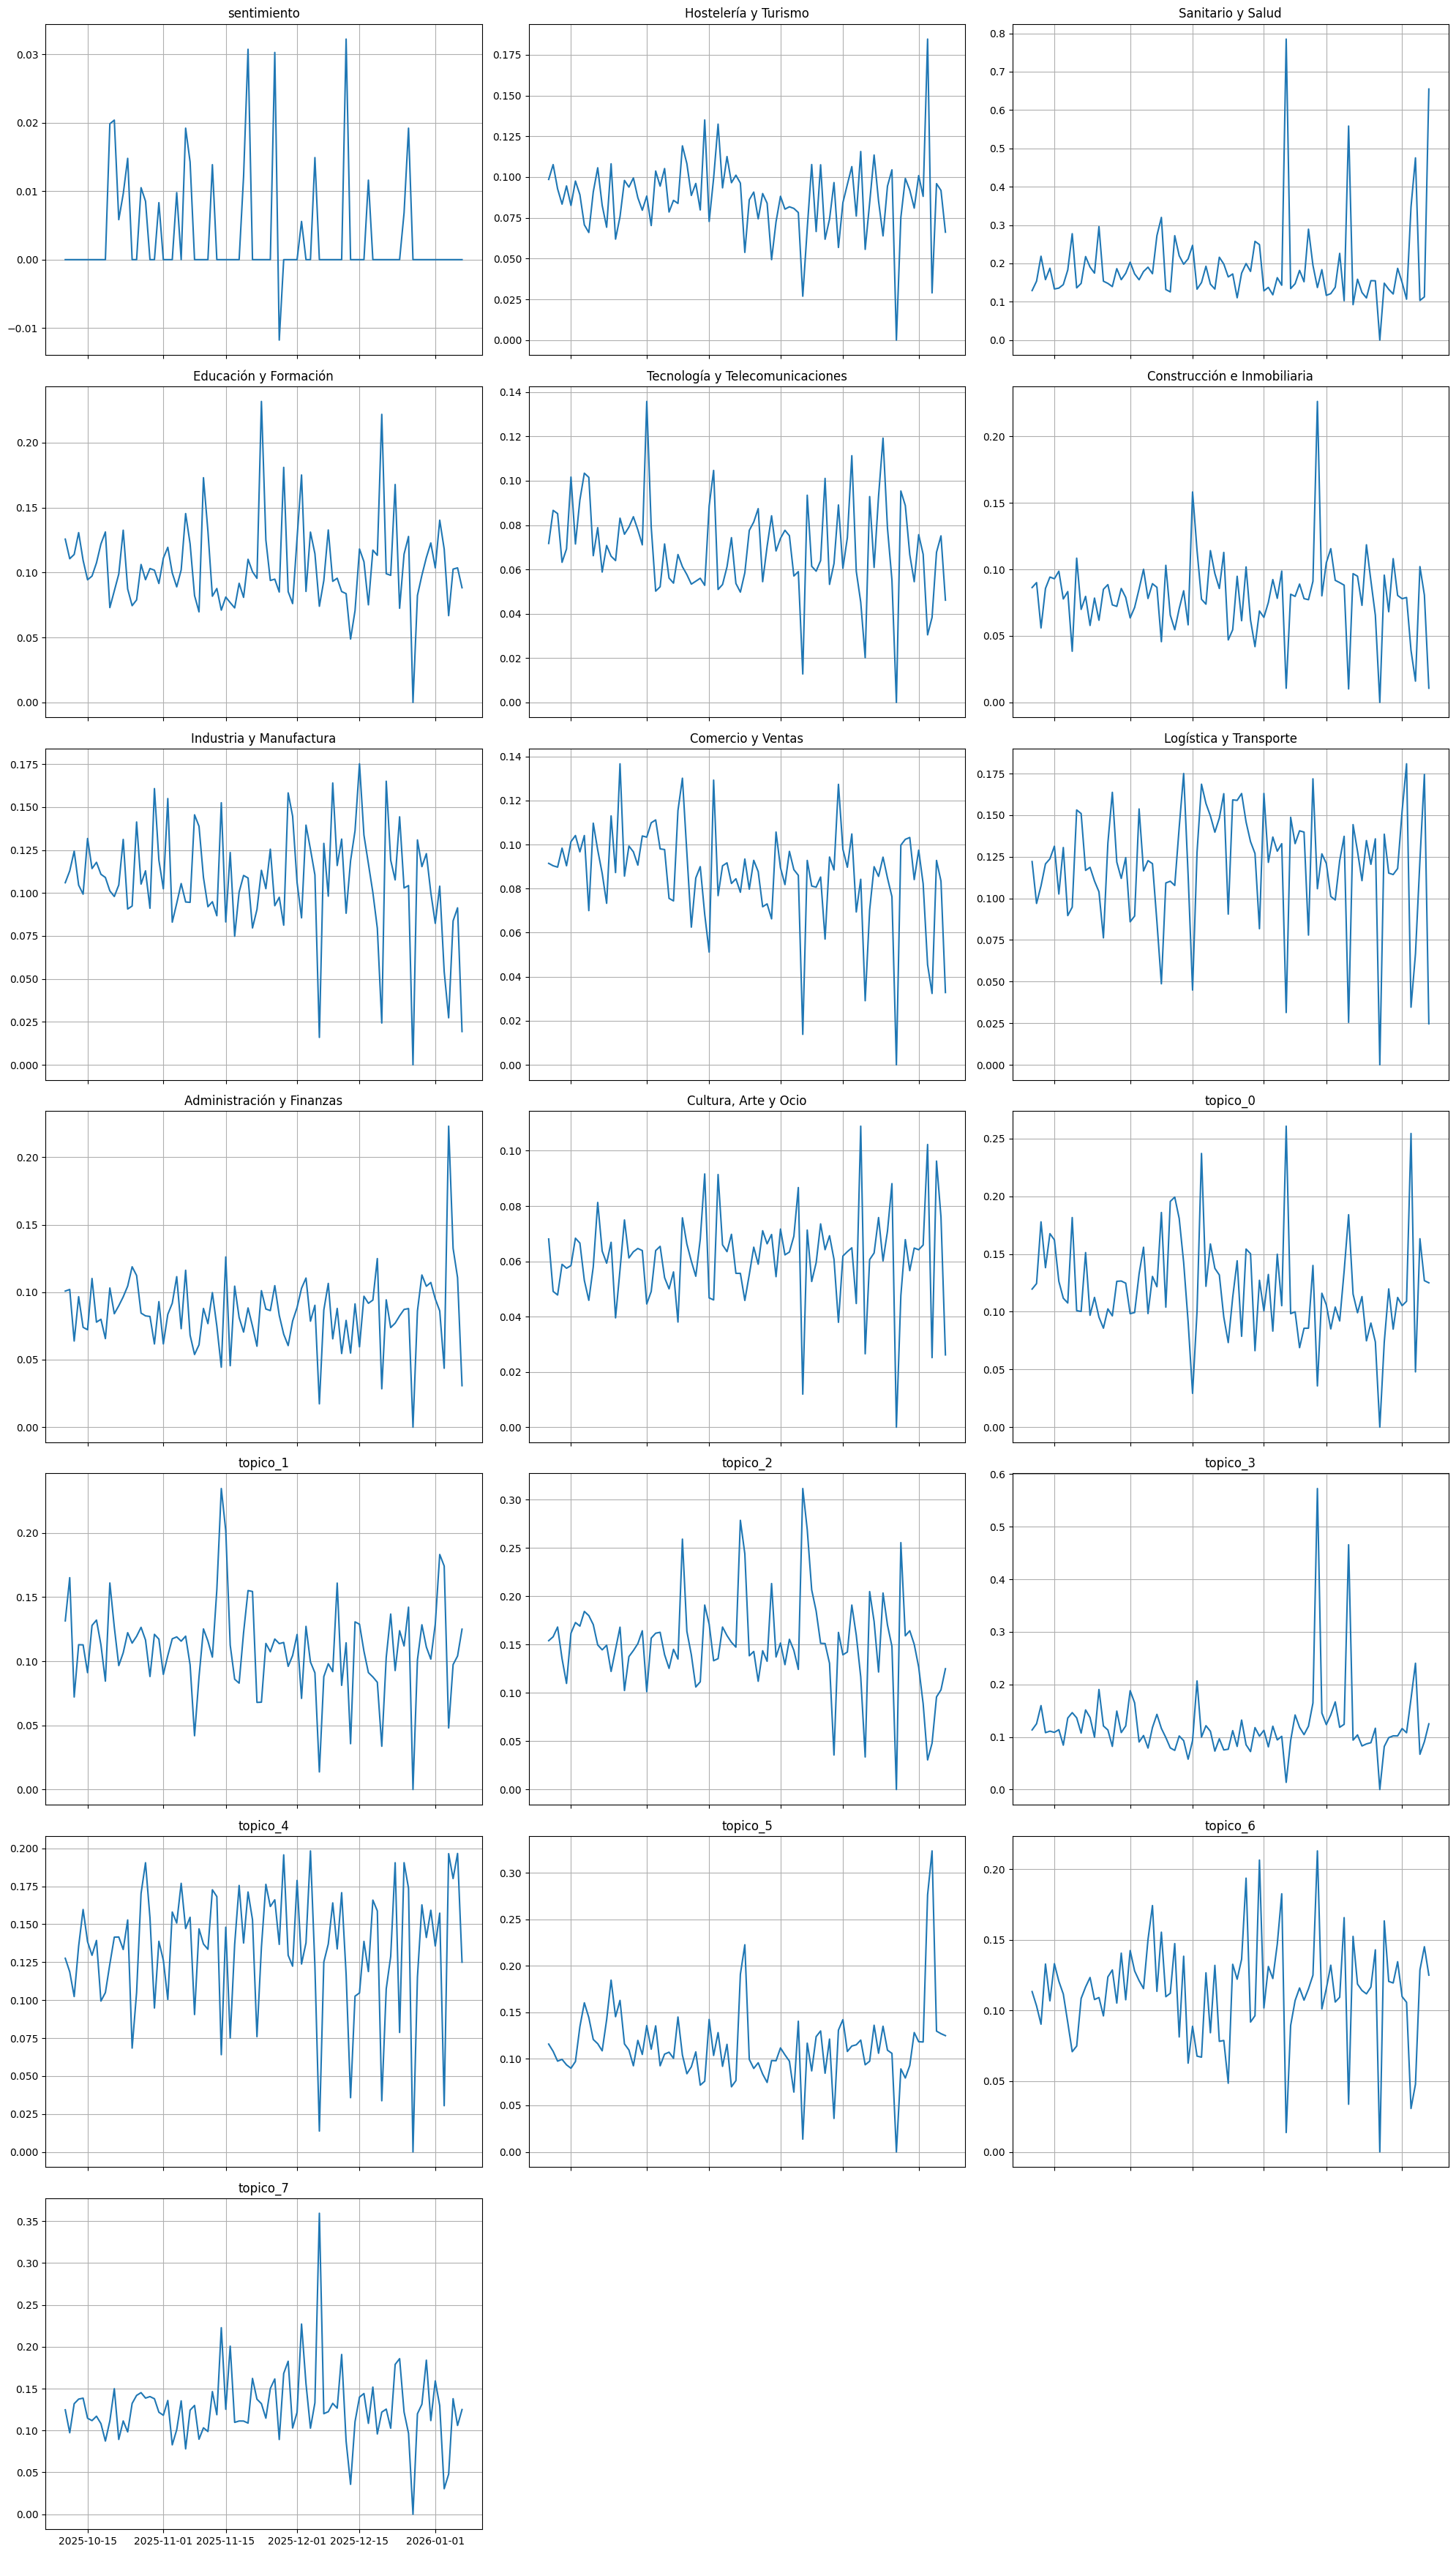

In [3]:
columnas_excluir = ["provincia", "titulo", "id", "timestamp"]
indicadores = [col for col in df.columns if col not in columnas_excluir]

# 3. Configurar subplots: 3 por fila
n_cols = 3
n_rows = int(np.ceil(len(indicadores) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True)
axes = axes.flatten()

# 4. Graficar cada indicador en su subplot
for i, indicador in enumerate(indicadores):
    series_diaria = agrupar(df, indicador, freq="D")
    axes[i].plot(series_diaria.index, series_diaria.values)
    axes[i].set_title(indicador)
    axes[i].grid(True)

# 5. Eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [4]:
# Lista de tópicos a procesar 
topicos = [col for col in df.columns if 'topico' in col]

series_dict = {}

for indicador in topicos:
    # Agrupar por días
    serie = agrupar(df, indicador, freq="D")
    serie = serie.replace(0, np.nan).ffill()
    series_dict[indicador] = serie

# Crear un nuevo DataFrame con todas las series procesadas
df_series_temporales = pd.DataFrame(series_dict)

df_series_temporales

,topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
timestamp,,,,,,,,
2025-10-10,0.119587,0.131459,0.153999,0.113355,0.127572,0.115938,0.113386,0.124704
2025-10-11,0.124357,0.165141,0.158053,0.125143,0.118666,0.108106,0.103245,0.097288
2025-10-12,0.177816,0.072119,0.168140,0.159695,0.102363,0.097574,0.090305,0.131989
2025-10-13,0.138142,0.112881,0.135292,0.108233,0.135611,0.099507,0.132872,0.137462
2025-10-14,0.167609,0.112767,0.109777,0.111071,0.159719,0.093592,0.106850,0.138615
...,...,...,...,...,...,...,...,...
2026-01-03,0.254355,0.174218,0.030620,0.172728,0.030433,0.276452,0.030719,0.030475
2026-01-04,0.047901,0.047996,0.047956,0.240220,0.196511,0.323616,0.047901,0.047900
2026-01-05,0.163206,0.097385,0.095829,0.067027,0.180086,0.129854,0.128644,0.137969


## Buscamos estacionariedad en las series temporales.

In [5]:
# 4. Test de estacionariedad (ADF)
resultados_adf = []

for column in df_series_temporales.columns:
    result = adfuller(df_series_temporales[column])
    adf_stat = result[0]
    p_value = round(result[1], 3)
    es_estacionaria = p_value < 0.05
    
    resultados_adf.append({
        'Topico': column,
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Estacionaria': es_estacionaria
    })

# Convertir a DataFrame para mejor visualización
pd.DataFrame(resultados_adf)


,Topico,ADF Statistic,p-value,Estacionaria
0,topico_0,-9.067007,0.000,True
1,topico_1,-3.463608,0.009,True
2,topico_2,-6.525954,0.000,True
3,topico_3,-8.377698,0.000,True
4,topico_4,-1.999306,0.287,False
5,topico_5,-6.454042,0.000,True
6,topico_6,-9.037406,0.000,True
7,topico_7,-8.698243,0.000,True


podemos ver que todos los tópicos salvo el 4 son estacionarios, por tanto tendremos que integrar el tópico 4 para conseguir estacionariedad

In [6]:
result = adfuller(df_series_temporales['topico_4'].diff().dropna())

adf_stat = result[0]
p_value = round(result[1], 3)
es_estacionaria = p_value < 0.05

resultado_diff = {
    'Topico': 'topico_4 (Diferenciado)',
    'ADF Statistic': adf_stat,
    'p-value': p_value,
    'Estacionaria': es_estacionaria}

# Mostrar el resultado como DataFrame
pd.DataFrame([resultado_diff])

,Topico,ADF Statistic,p-value,Estacionaria
0,topico_4 (Diferenciado),-8.218494,0.0,True


El número mínimo de diferenciaciones necesarias para hacer la serie estacionaria es $\mathbf{d=1}$. Este es el valor que debe utilizar en su modelo ARIMA, es decir, $\text{ARIMA}(p, \mathbf{1}, q)$.

## Buscamos estacionalidad en las series temporales.

In [7]:
df_series_temporales.shape

(90, 8)

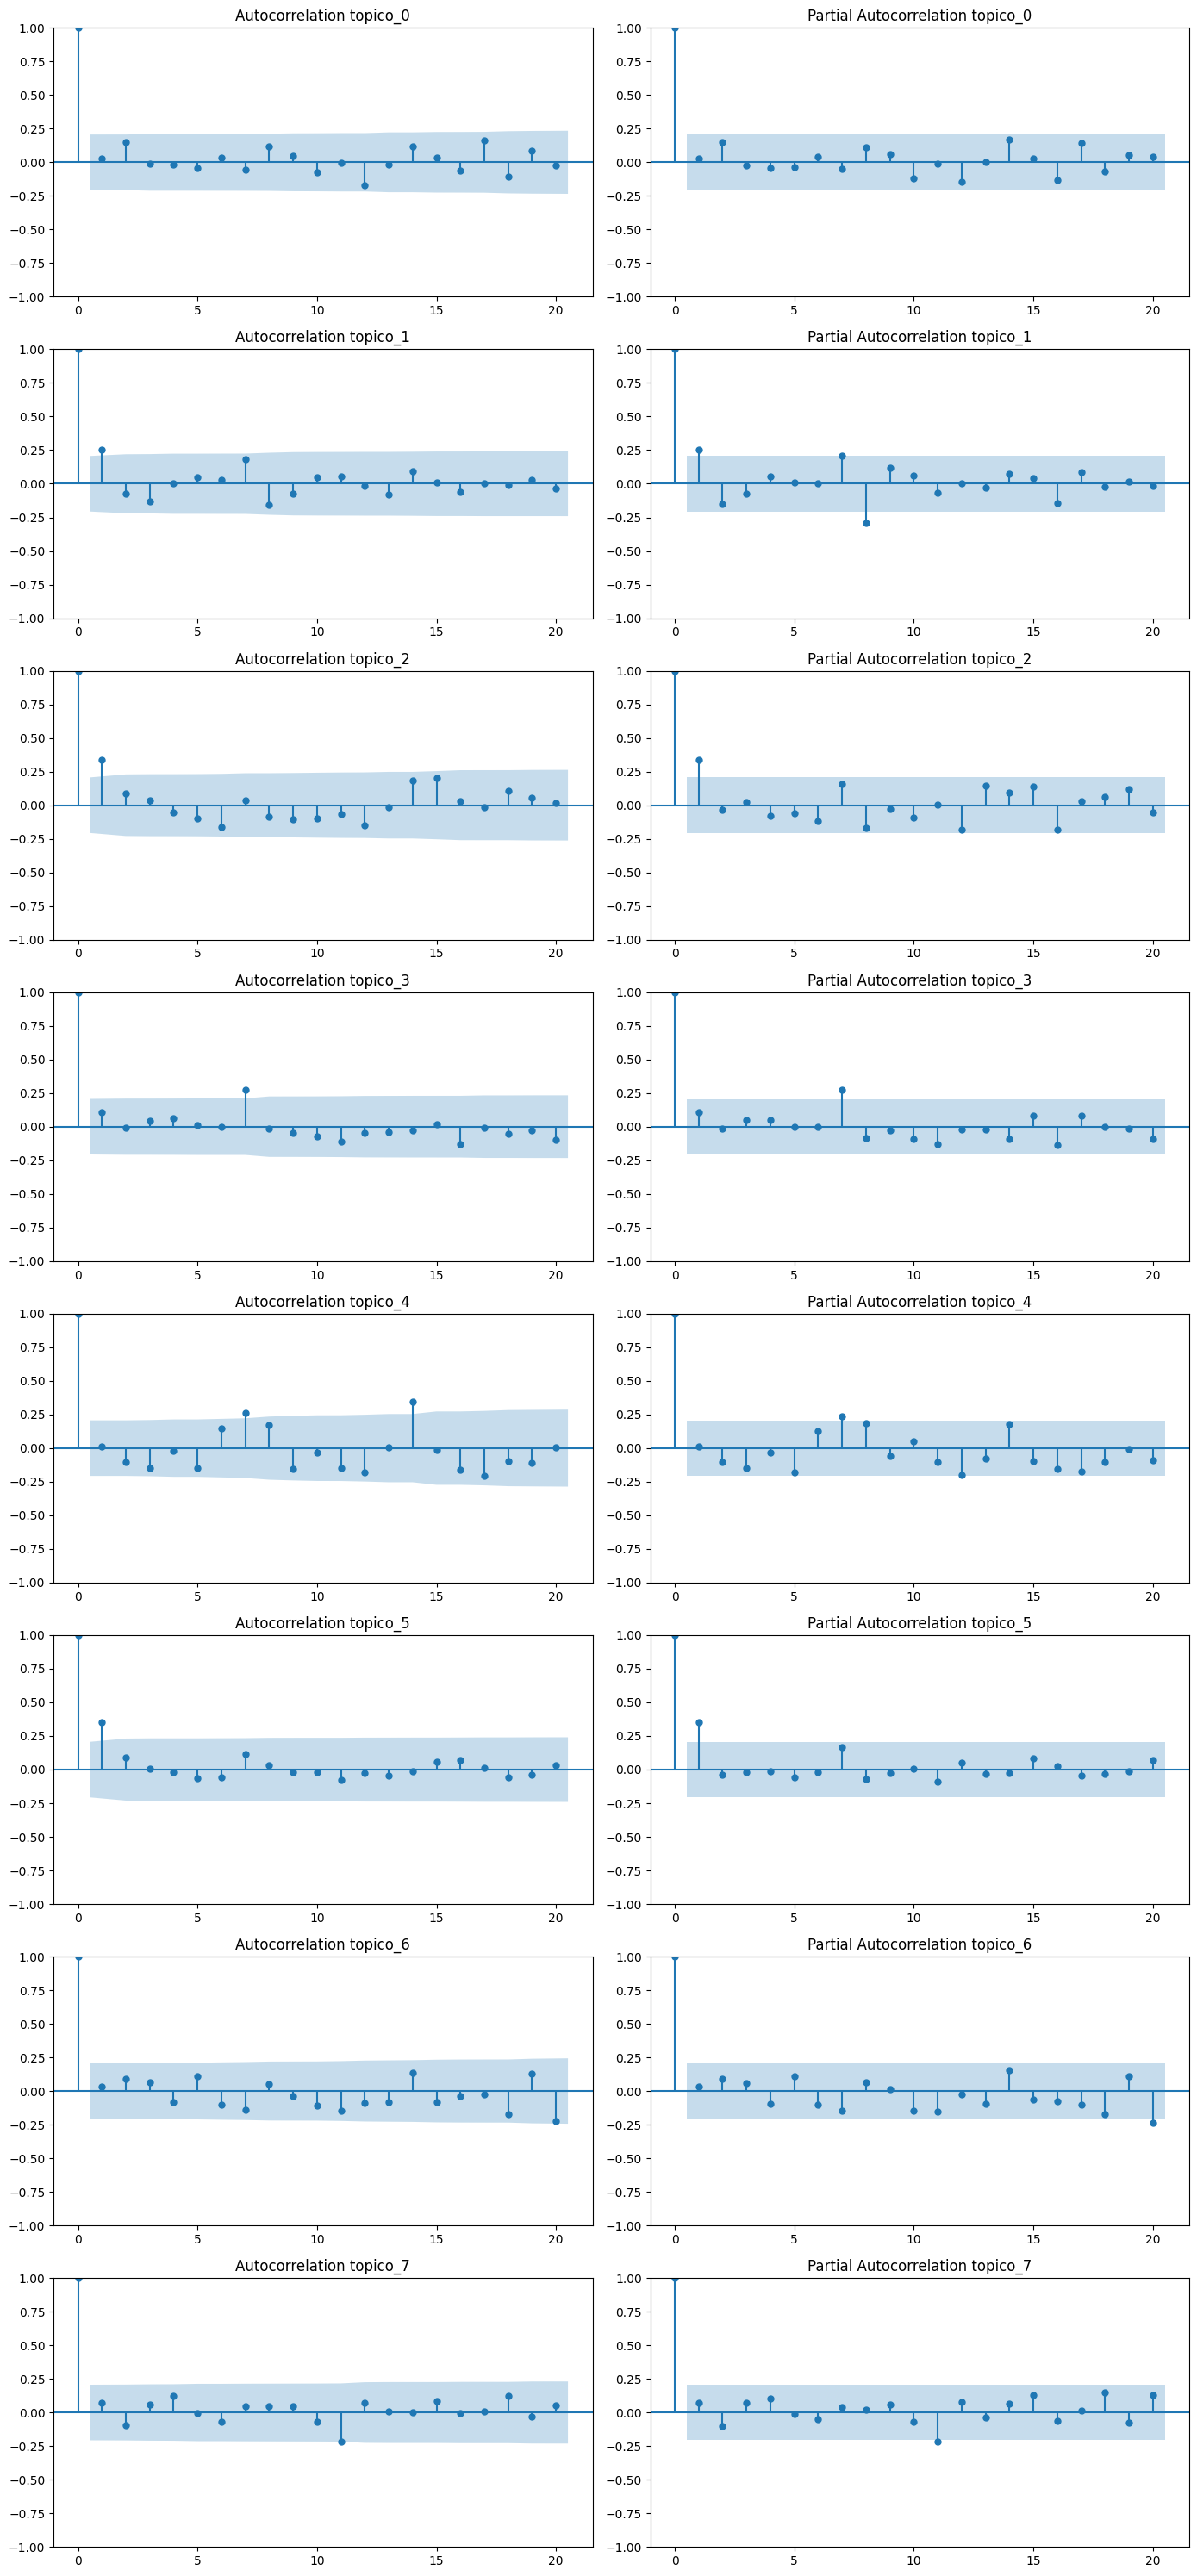

In [8]:
fig, axes = plt.subplots(8, 2, figsize=(14, 30))

for i, column in enumerate(df_series_temporales.columns):

    plot_acf(df_series_temporales[column], lags=20, ax=axes[i, 0], title=f'Autocorrelation {column}')
    plot_pacf(df_series_temporales[column], lags=20, ax=axes[i, 1], title=f'Partial Autocorrelation {column}')

plt.tight_layout()
plt.show()

### Análisis de estacionalidad

##### Tópico 4
Este es el único tópico que el test de Dickey-Fuller identificó como no estacionario con un p-value muy alto de 0.872. Esto indica que la serie debe ser tratada con diferenciación.

Al observar sus correlogramas (ACF/PACF), destaca un patrón de dependencia estacional significativa cada 7 y 14 días. Para capturar esta estructura, un suavizado exponencial simple no es suficiente.

##### Tópicos 1 y 3
Ambos tópicos presentan un p-value de 0.000 en el test ADF, lo que confirma que las series son estacionarias.

Sin embargo, al analizar sus correlogramas, observamos una estacionalidad clara cada 7 días en ambos casos.  Esto nos indica que su comportamiento parece estar regido por un ciclo semanal.

##### Resto de Tópicos (0, 2, 5, 6, 7)
Estos tópicos no parecen estacionarios, aunque algunos muestran una ligera influencia del día inmediatamente anterior (como el 2 y el 5), esto refleja una memoria muy corta y no una estructura cíclica que justifique un modelo estacional complejo.

## Analizamos tendencias en las series temporales.

#### Topico 1, 3 y 4 con tendencias de 7 días
Aplicamos seasonal decompose

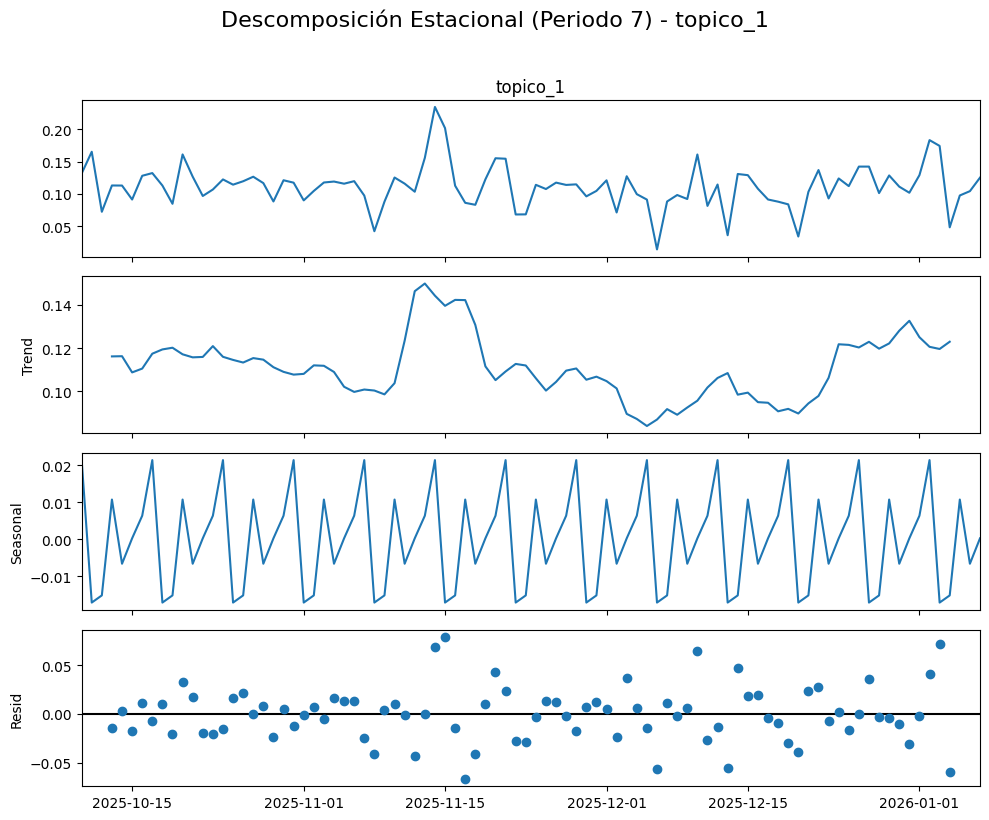

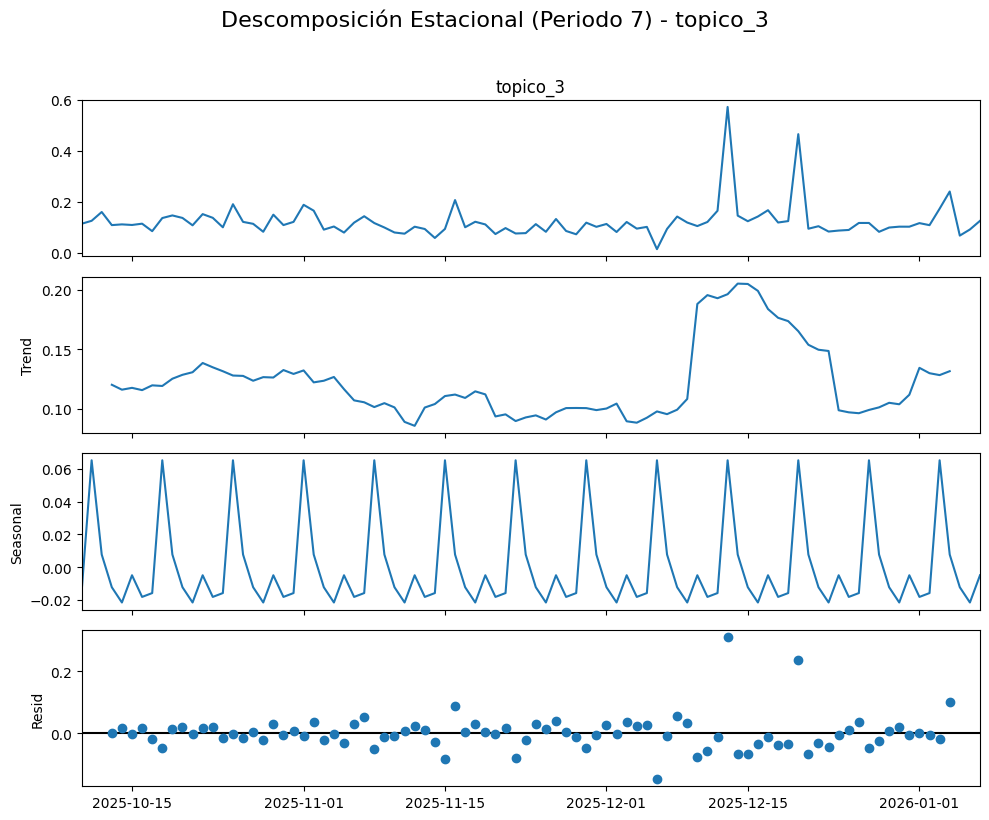

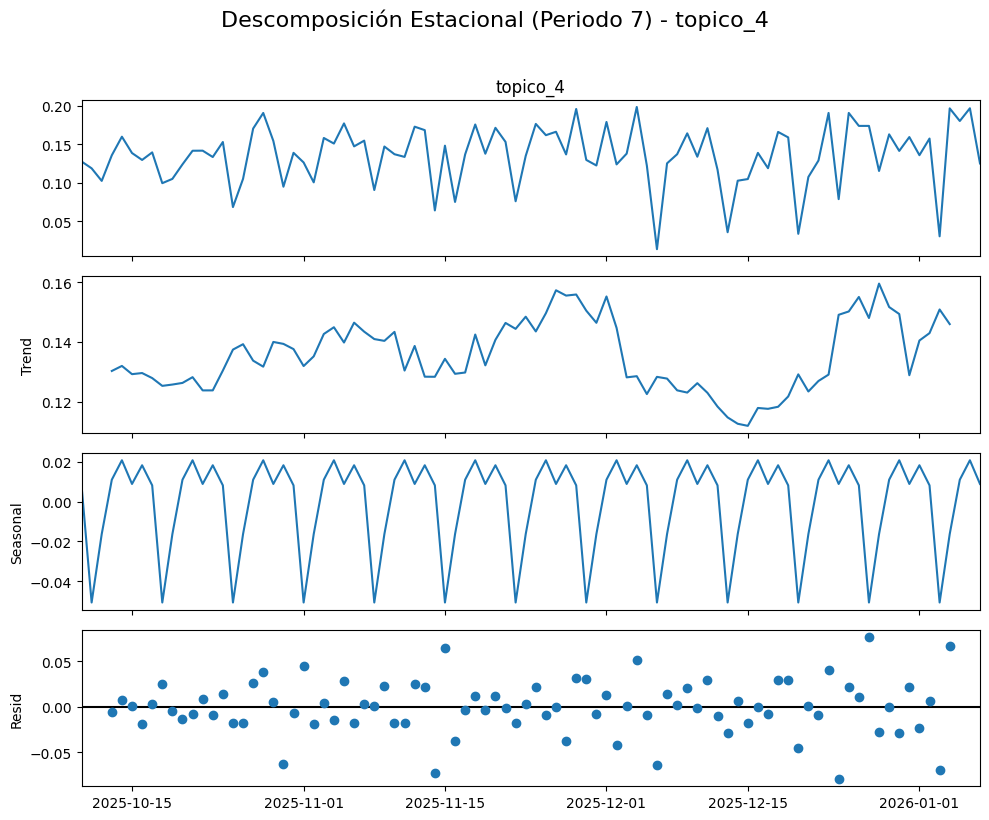

In [9]:
# Procesamos los tópicos que presentan patrones estacionales semanales (1, 3 y 4)
topicos_estacionales = ['topico_1', 'topico_3', 'topico_4']

for column in topicos_estacionales:
    if column in df_series_temporales.columns:
        series = df_series_temporales[column]
        
        # Descomposición Aditiva con periodo de 7 días
        # Se aplica a estos tópicos dado su claro componente cíclico semanal
        result = seasonal_decompose(series, model="additive", period=7)

        fig = result.plot()
        fig.set_size_inches(10, 8)
        fig.suptitle(f"Descomposición Estacional (Periodo 7) - {column}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

#### Resto de topicos

Como no tienen estacionalidad, calculamos la media movil para buscar la tendencia

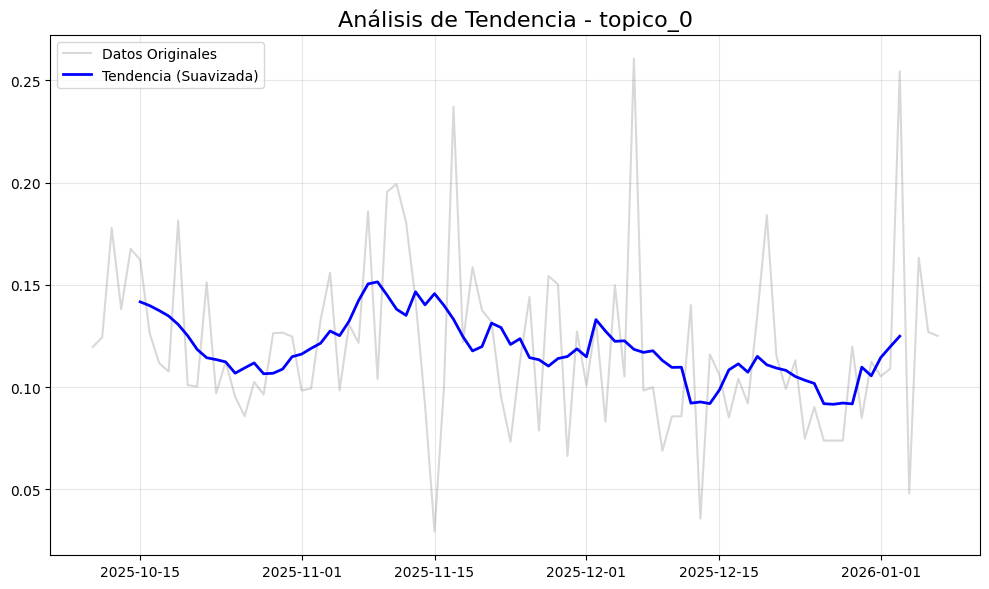

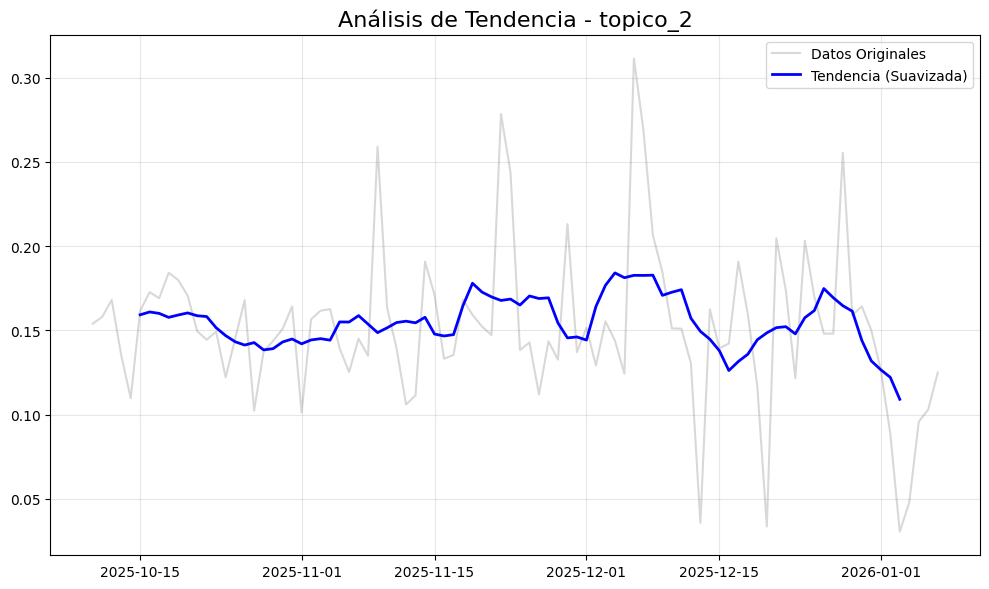

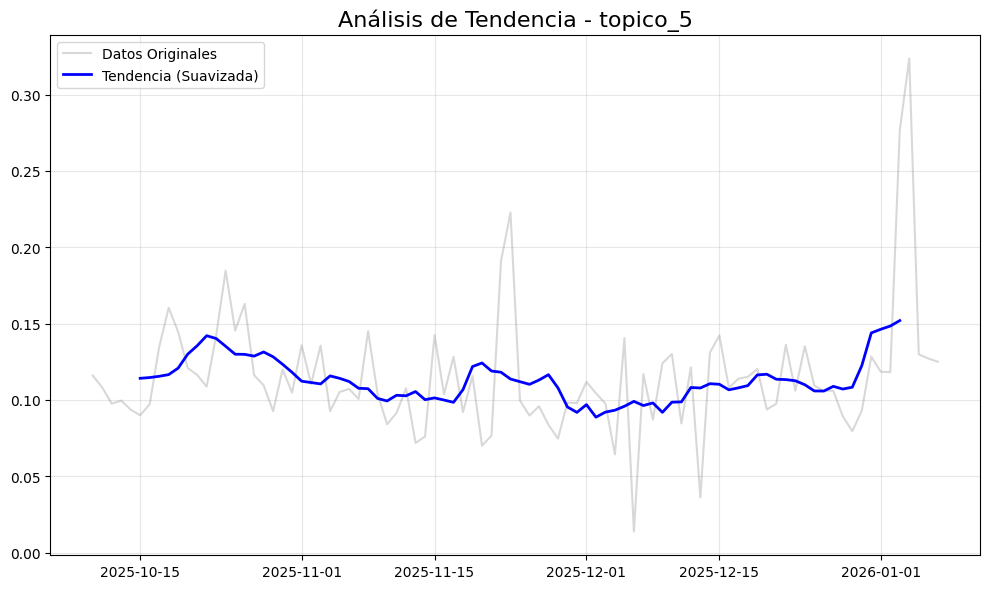

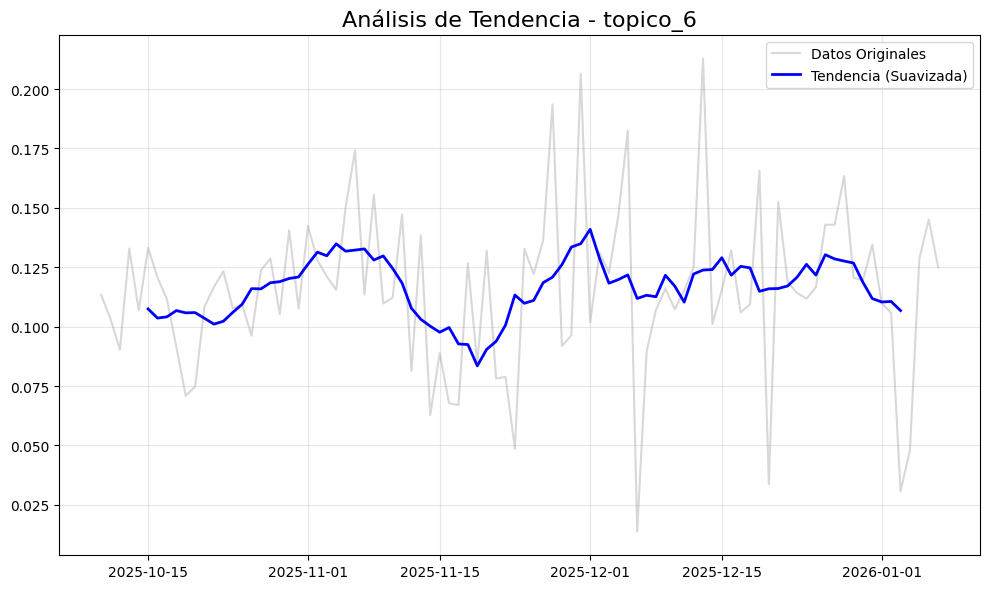

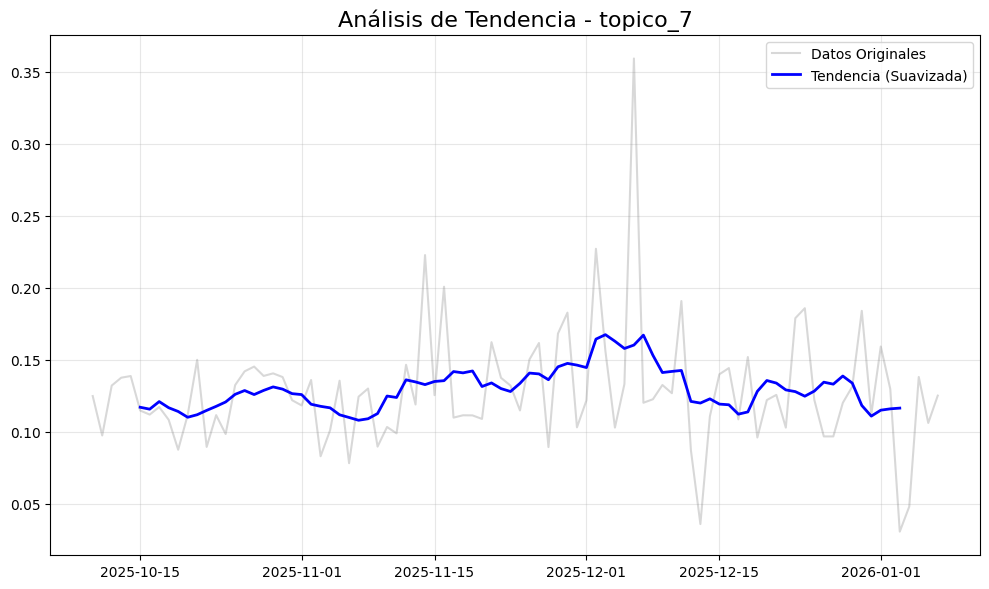

In [10]:
# Procesamos el resto de tópicos (aquellos sin estacionalidad definida)

# El resto de tópicos: Aquellos que no están en la lista de estacionales
topicos_simple = [c for c in df_series_temporales.columns if c not in topicos_estacionales]

for column in topicos_simple:
    series = df_series_temporales[column]
    
    # Calculamos TENDENCIA (Media móvil centrada para suavizar ruido)
    tendencia = series.rolling(window=10, center=True).mean()
    
    plt.figure(figsize=(10, 6))
    # Datos originales de fondo
    plt.plot(series, label='Datos Originales', alpha=0.3, color='gray')
    # Tendencia marcada
    plt.plot(tendencia, label='Tendencia (Suavizada)', color='blue', linewidth=2)
    
    plt.title(f"Análisis de Tendencia - {column}", fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Análisis de Tendencia

En lo referente a los **Tópicos 1 y 3**, la descomposición captura picos significativos de actividad (en noviembre para el Tópico 1 y diciembre para el Tópico 3), que se reflejan como subidas bruscas y aisladas en la tendencia. En el caso del Tópico 3, esto sugiere la presencia de una anomalía específica o un shock exógeno, respaldando la hipótesis planteada en el estudio: *"Las ofertas del sector logístico presentan mayor actividad en el inicio de diciembre, en preparación para la campaña navideña"*. Con respecto al Tópico 1 no podemos añadir información adicional sobre sus causas por que no hay nigún sector determinante ni plateamos ninguna hipótesis respeto a el. Descartando estos eventos puntuales, ninguna de las dos series muestra una tendencia significativa a largo plazo, retornando a sus niveles base tras los periodos de mayor actividad.

Respecto al **Tópico 4**, se observa una tendencia "nerviosa" que confirma la no estacionariedad estadística de la serie. Sin embargo, la tendencia oscila constantemente sin una dirección determinada y, por tanto, consideramos que no se detecta una tendencia sostenida de crecimiento o decrecimiento.

Finalmente, de carácter general, el **resto de tópicos (0, 2, 5, 6 y 7)** no presentan ninguna tendencia direccional a destacar. A diferencia de los casos anteriores, estos tópicos exhiben un comportamiento estacionario en media, oscilando alrededor de valores constantes con desviaciones similares entre sí. Aunque se observan picos puntuales de volatilidad, estos no se traducen en cambios estructurales y son considerados como ruido.

## Aplicación de suavizado exponencial 

#### Tópico 1, 3 y 4
Tópicos 1, 3 y 4 (Con Estacionalidad): Al tener un ciclo de 7 días, usaremos Holt-Winters (Triple Suavizado).

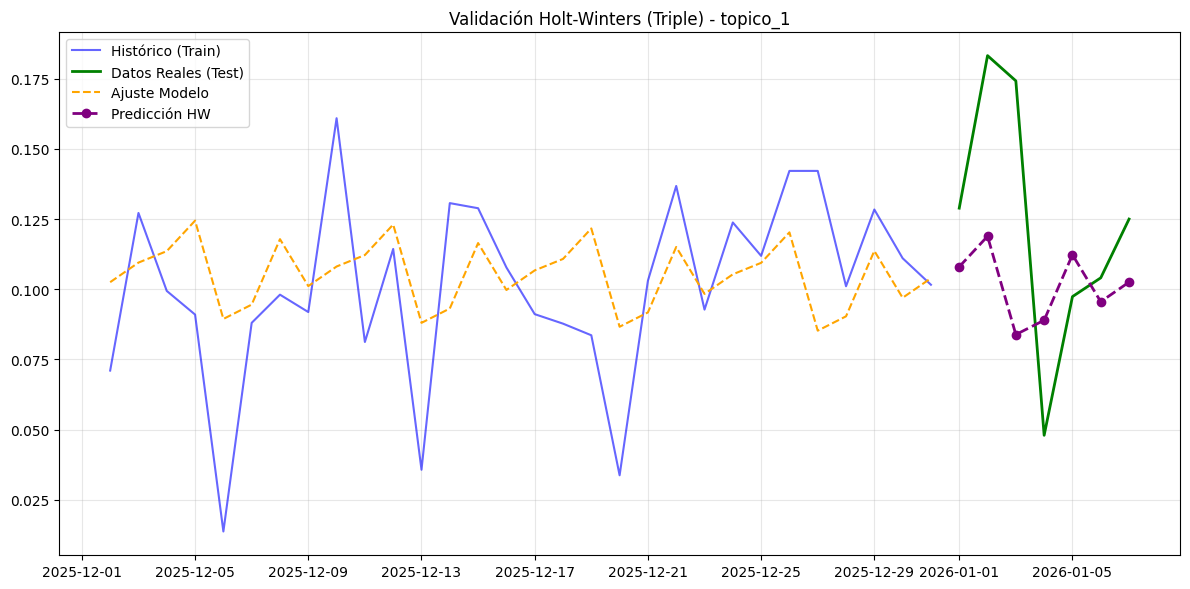

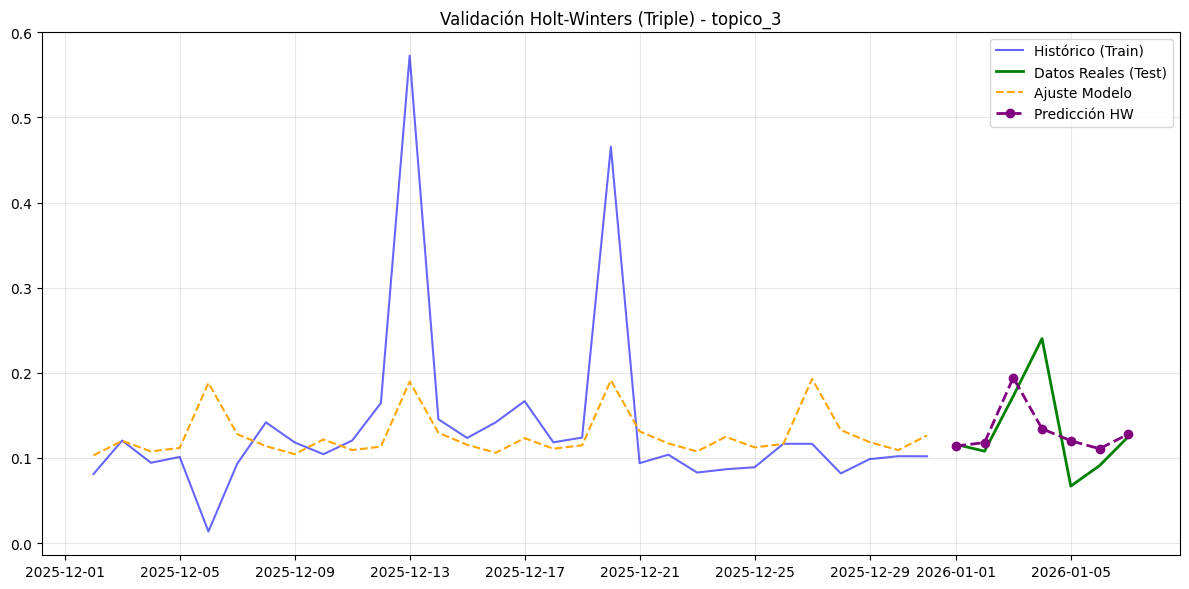

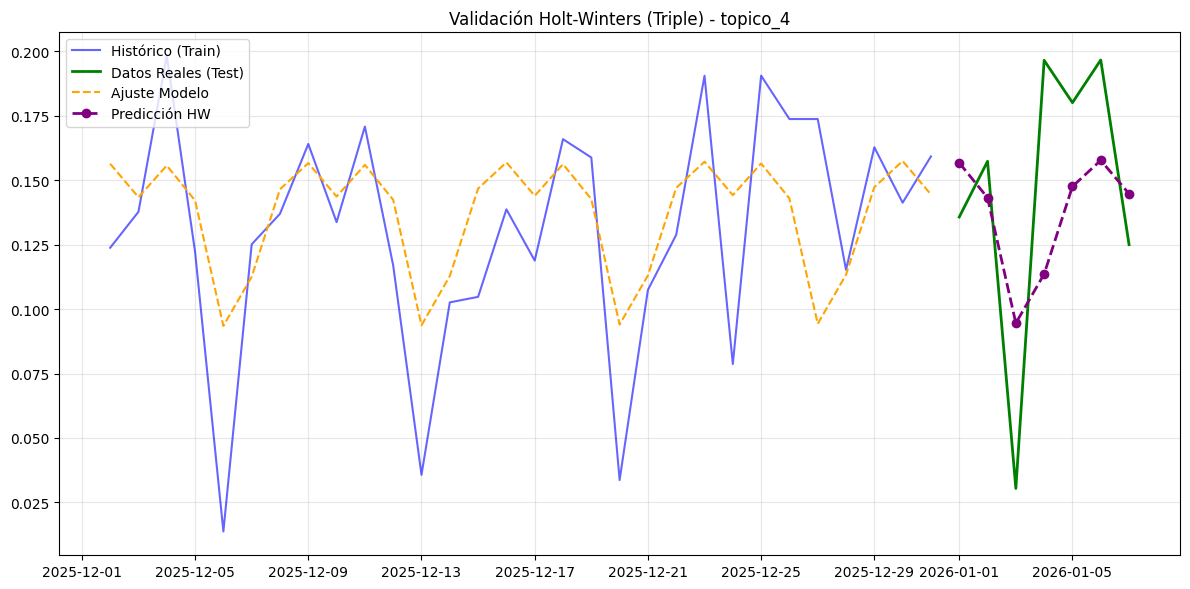

In [11]:
future_days = 7

for column in topicos_estacionales:
    if column in df_series_temporales.columns:
        series = df_series_temporales[column]
        
        # 1. Dividir en Train y Test
        # Usamos todos los datos menos los últimos 7 días para entrenar
        train_series = series[:-future_days]
        test_series = series[-future_days:]
        
        # 2. Modelo Holt-Winters (Triple Suavizado) sobre TRAIN
        # trend='add': Para capturar cambios en el nivel (tendencia local)
        # seasonal='add': Para modelar el ciclo semanal aditivo
        # seasonal_periods=7: Ciclo de 7 días
        model = ExponentialSmoothing(
            train_series, 
            trend='add', 
            seasonal='add', 
            seasonal_periods=7
        ).fit()
        
        # 3. Obtener valores ajustados (Train) y predicción (Test)
        fitted_values = model.fittedvalues
        forecast_values = model.forecast(future_days)
        
        # 4. Gráfico con el diseño solicitado
        plt.figure(figsize=(12, 6))
        
        # a) Datos Reales
        # Mostramos solo los últimos 30 días del train para hacer zoom en la zona de interés
        plt.plot(train_series.index[-30:], train_series.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
        plt.plot(test_series.index, test_series, label='Datos Reales (Test)', color='green', linewidth=2)
        
        # b) Modelo
        # Ajuste sobre los datos de entrenamiento
        plt.plot(fitted_values.index[-30:], fitted_values.tail(30), label='Ajuste Modelo', color='orange', linestyle='--')
        # Predicción sobre los datos de prueba
        plt.plot(forecast_values.index, forecast_values, label='Predicción HW', linestyle='--', marker='o', color='purple', linewidth=2)
        
        plt.title(f'Validación Holt-Winters (Triple) - {column}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

#### Resto de tópicos
Resto de Tópicos (Sin Estacionalidad, Sin Tendencia): Al no tener componentes sistemáticos, usamos Suavizado Exponencial Simple, que simplemente estima filtrando el ruido.

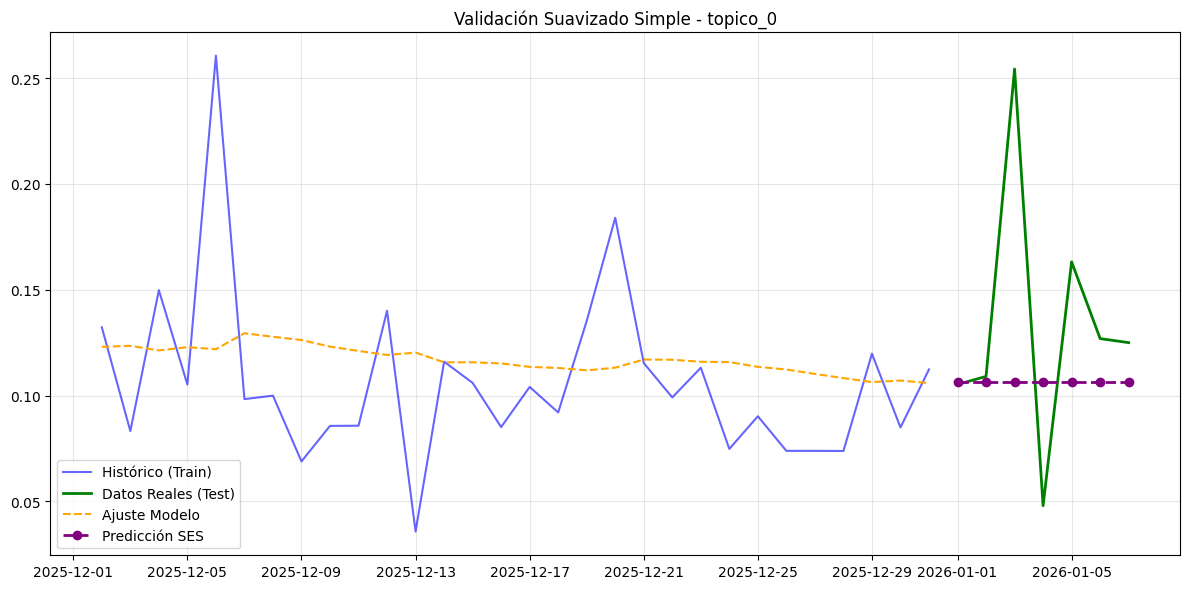

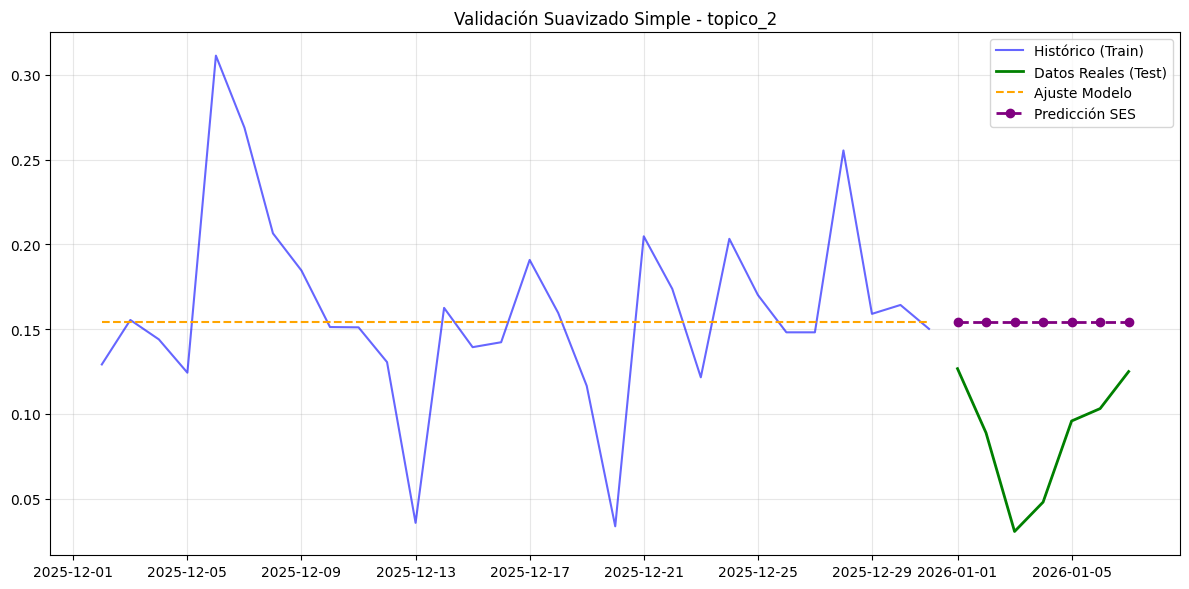

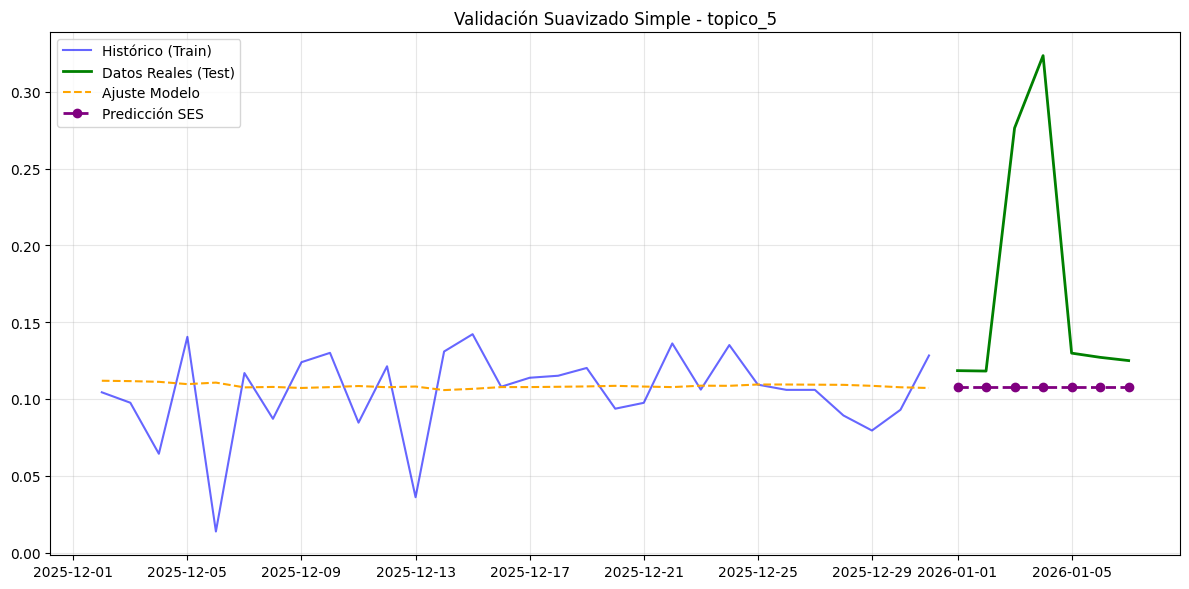

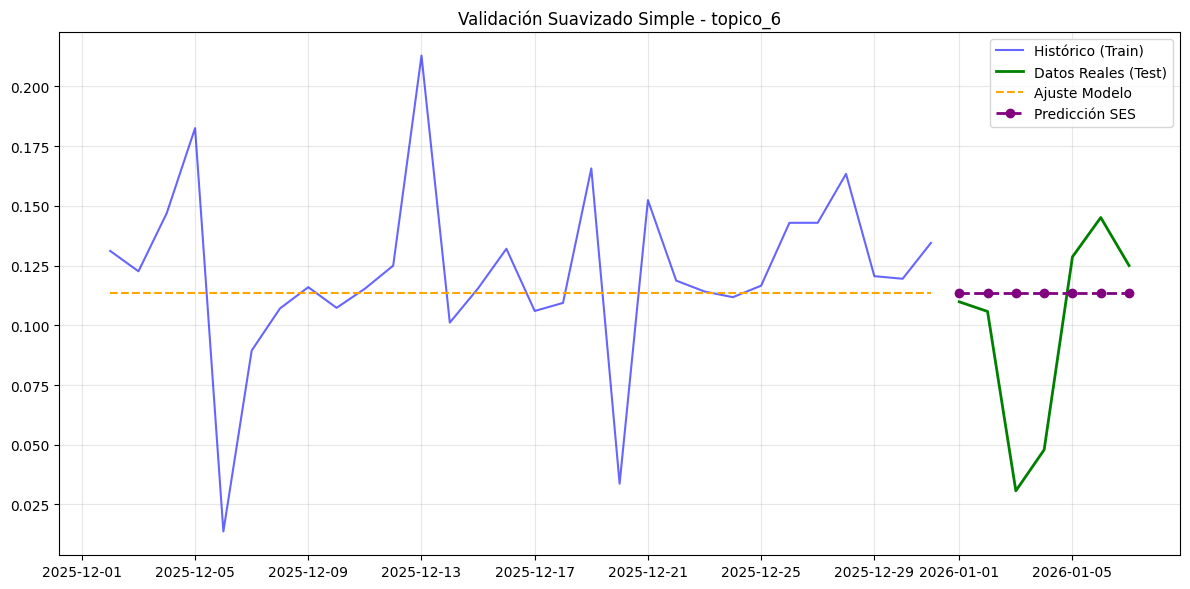

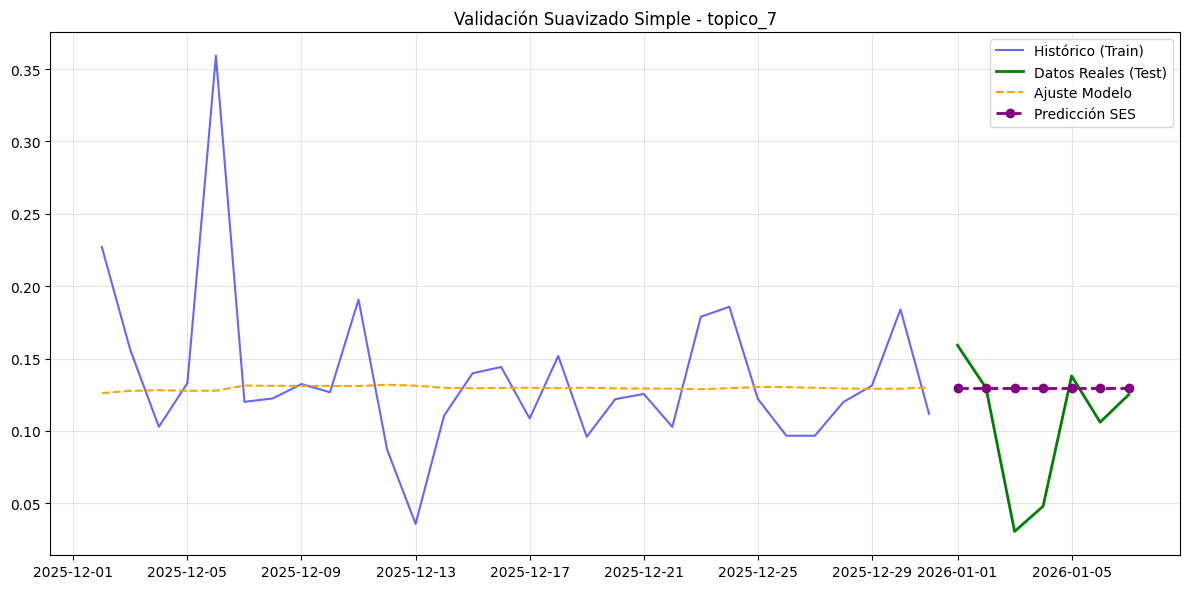

In [12]:
future_days = 7

for column in topicos_simple:
    series = df_series_temporales[column]
    
    # 1. Dividir en Train y Test
    train_series = series[:-future_days]
    test_series = series[-future_days:]
    
    # 2. Modelo Suavizado Simple (SES) sobre TRAIN
    # Asume nivel constante (sin tendencia ni estacionalidad)
    model = SimpleExpSmoothing(train_series).fit()
    
    # 3. Obtener valores ajustados y predicción
    fitted_values = model.fittedvalues
    forecast_values = model.forecast(future_days)
    
    # 4. Gráfico
    plt.figure(figsize=(12, 6))
    
    # a) Datos Reales
    plt.plot(train_series.index[-30:], train_series.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
    plt.plot(test_series.index, test_series, label='Datos Reales (Test)', color='green', linewidth=2)
    
    # b) Modelo
    plt.plot(fitted_values.index[-30:], fitted_values.tail(30), label='Ajuste Modelo', color='orange', linestyle='--')
    plt.plot(forecast_values.index, forecast_values, label='Predicción SES', linestyle='--', marker='o', color='purple', linewidth=2)
    
    plt.title(f'Validación Suavizado Simple - {column}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Análisis Suavizado exponencial

Para los **Tópicos 1, 3 y 4**, al aplicar el modelo de triple suavizado (Holt-Winters), el modelo logra capturar correctamente la fase del ciclo (acierta en las subidas y bajadas semanales), vuelve a corroborar la estacionalidad de 7 días. Sin embargo, la predicción no es perfecta en cuanto a magnitud por que el modelo tiende a ser conservador y el componente aleatorio tiene un peso muy significativo que cuesta predecir con exactitud. 

Para el **resto de tópicos (0, 2, 5, 6 y 7)**, la aplicación del Suavizado Exponencial Simple arroja una predicción plana. Este resultado tiene sentido ya que al no considerar ni tendencia ni estacionalidad, el modelo determina que la mejor predicción posible es el nivel medio actual. La gran diferencia entre la predicción y los datos reales ilustra un nivel de ruido muy intenso, lo que nos puede dar a pensar que existe alguna influencia exogenea en las series. 

## Aplicación SARIMA

Los tópicos estacionales son siempre cada 7 dias, por tanto el valor estacional es siempre 7. Para todos los topicos salvo el 4 (donde d=1), el valor de d=0 ya que no requiere diferenciación para lograr ser estacionaria.

Para determinar los parámetros óptimos (p, q, P, Q) de cada modelo, hemos implementado una Grid Search que evalúa múltiples combinaciones respetando las restricciones de integración y estacionalidad de cada tópico.

La selección del mejor modelo se ha basado en minimizar el Criterio de Información de Akaike (AIC). Hemos preferido el AIC sobre el BIC porque nuestro objetivo es maximizar la capacidad predictiva a corto plazo. El AIC estima mejor el error de predicción futuro y evita el riesgo de seleccionar modelos demasiado simples que el BIC podría favorecer al penalizar, además nuestra muestra no es demasido densa y el BIC tiende a tener mejor desempeño cuando la muestra es grande, para evitar el sobreajuste.


In [13]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Función para buscar los mejores parámetros p, q (y P, Q) dado un d, D, s fijos
def grid_search_sarima(series, d, D, s, seasonal=True):
    p = q = range(0, 6)
    if seasonal:
        P = Q = range(0, 2) # P y Q estacionales suelen ser bajos 
        # Generamos combinaciones: (p, d, q) x (P, D, Q, s)
        pdq = [(x[0], d, x[1]) for x in list(itertools.product(p, q))]
        seasonal_pdq = [(x[0], D, x[1], s) for x in list(itertools.product(P, Q))]
        combinations = list(itertools.product(pdq, seasonal_pdq))
    else:
        # Solo (p, d, q)
        combinations = [(x[0], d, x[1]) for x in list(itertools.product(p, q))]
        seasonal_pdq = [(0, 0, 0, 0)] 

    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    print(f"Buscando mejores parámetros para d={d}, D={D}, s={s}...")
    
    warnings.filterwarnings("ignore") # Ignorar warnings de convergencia

    for param in combinations:
        try:
            if seasonal:
                order = param[0]
                seasonal_order = param[1]
            else:
                order = param
                seasonal_order = (0, 0, 0, 0)

            model = SARIMAX(series,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
                
        except:
            continue
            
    print(f"  -> Mejor AIC: {best_aic:.2f} | Order: {best_order} | Seasonal: {best_seasonal_order}")
    return best_model, best_order, best_seasonal_order

topico 4

Buscando mejores parámetros para d=1, D=1, s=7...
  -> Mejor AIC: -245.32 | Order: (1, 1, 1) | Seasonal: (0, 1, 0, 7)


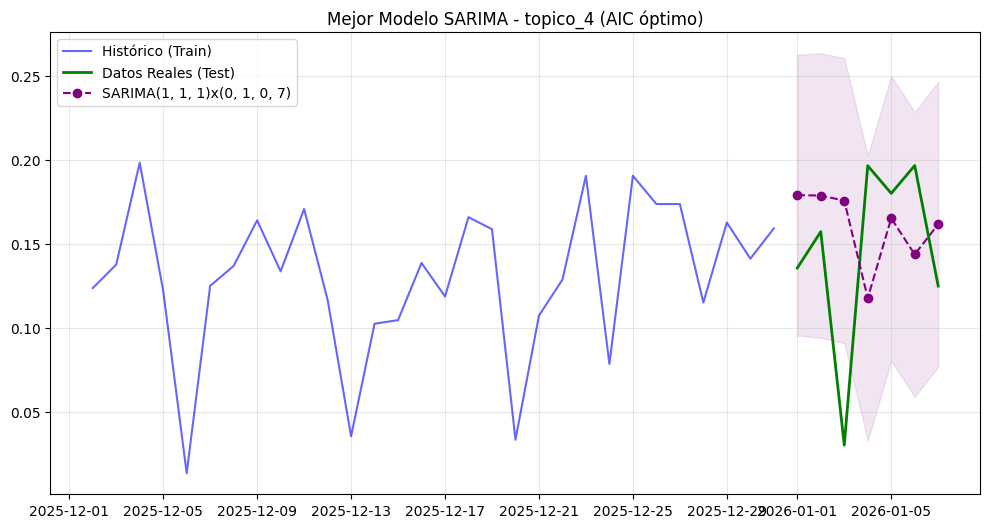

In [14]:
nombre_topico = 'topico_4'
series = df_series_temporales[nombre_topico]
future_days = 7

# Train/Test
train = series[:-future_days]
test = series[-future_days:]

# Grid Search con d=1, D=1, s=7
best_model, order, seasonal_order = grid_search_sarima(train, d=1, D=1, s=7, seasonal=True)

# Predicción
forecast = best_model.get_forecast(steps=future_days)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(train.index[-30:], train.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=2)
plt.plot(pred_mean.index, pred_mean, label=f'SARIMA{order}x{seasonal_order}', color='purple', marker='o', linestyle='--')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='purple', alpha=0.1)
plt.title(f'Mejor Modelo SARIMA - {nombre_topico} (AIC óptimo)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Topicos 1 y 3


--- Analizando topico_1 ---
Buscando mejores parámetros para d=0, D=1, s=7...
  -> Mejor AIC: -274.43 | Order: (2, 0, 0) | Seasonal: (0, 1, 0, 7)


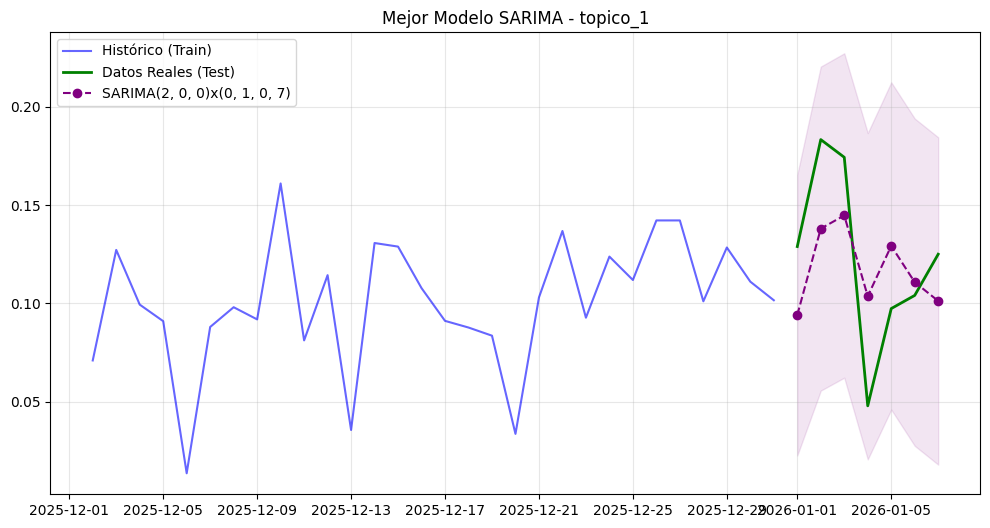


--- Analizando topico_3 ---
Buscando mejores parámetros para d=0, D=1, s=7...
  -> Mejor AIC: -151.91 | Order: (1, 0, 0) | Seasonal: (0, 1, 0, 7)


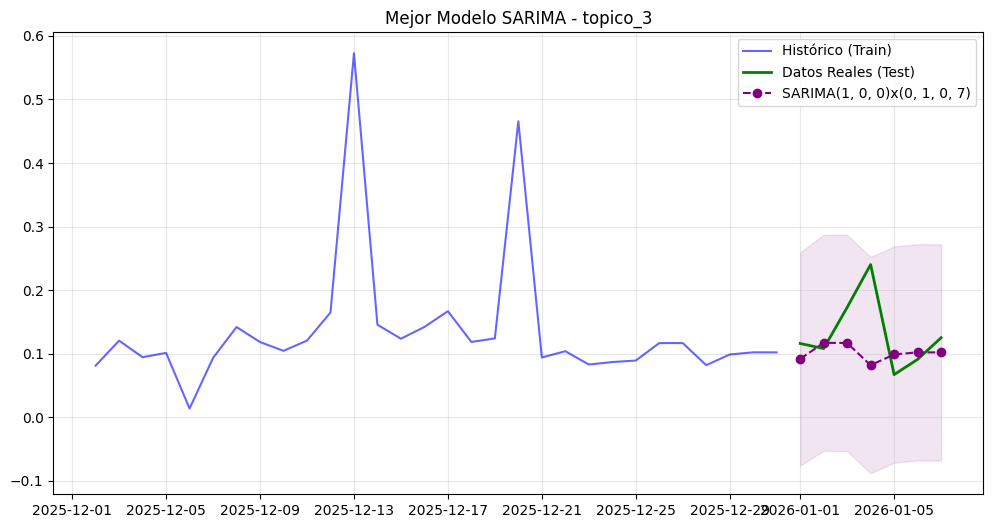

In [15]:
topicos_estacionales_st = ['topico_1', 'topico_3']

for nombre_topico in topicos_estacionales_st:
    if nombre_topico in df_series_temporales.columns:
        series = df_series_temporales[nombre_topico]
        train = series[:-future_days]
        test = series[-future_days:]
        
        print(f"\n--- Analizando {nombre_topico} ---")
        # Grid Search con d=0, D=1, s=7
        best_model, order, seasonal_order = grid_search_sarima(train, d=0, D=1, s=7, seasonal=True)
        
        forecast = best_model.get_forecast(steps=future_days)
        pred_mean = forecast.predicted_mean
        pred_ci = forecast.conf_int()
        
        plt.figure(figsize=(12, 6))
        plt.plot(train.index[-30:], train.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
        plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=2)
        plt.plot(pred_mean.index, pred_mean, label=f'SARIMA{order}x{seasonal_order}', color='purple', marker='o', linestyle='--')
        plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='purple', alpha=0.1)
        plt.title(f'Mejor Modelo SARIMA - {nombre_topico}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

Resto de topicos (ARIMA Simple)


--- Analizando topico_0 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -287.10 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


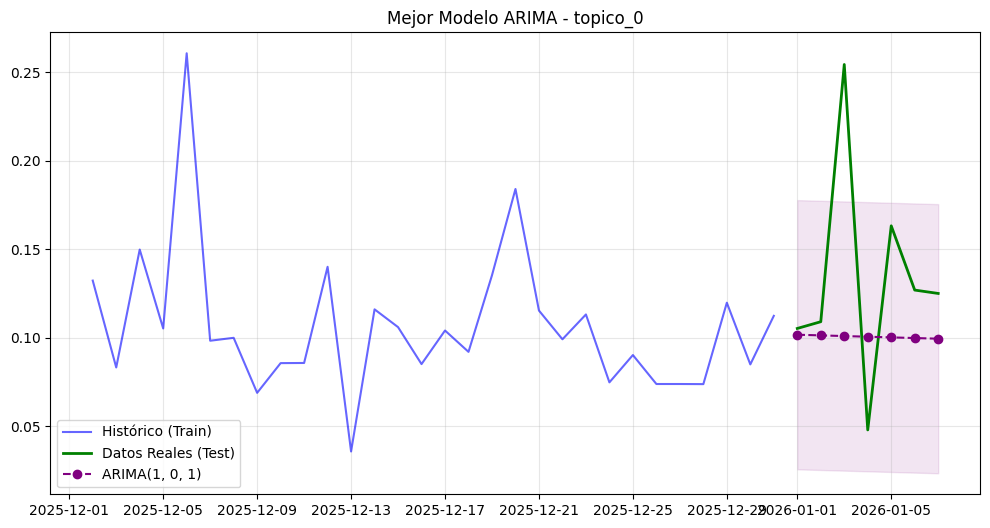


--- Analizando topico_2 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -268.86 | Order: (2, 0, 1) | Seasonal: (0, 0, 0, 0)


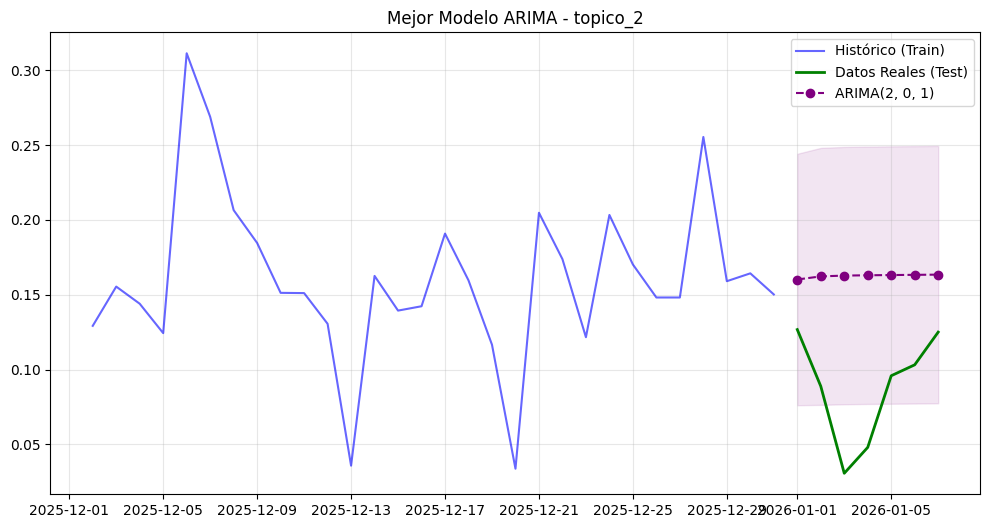


--- Analizando topico_5 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -327.78 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


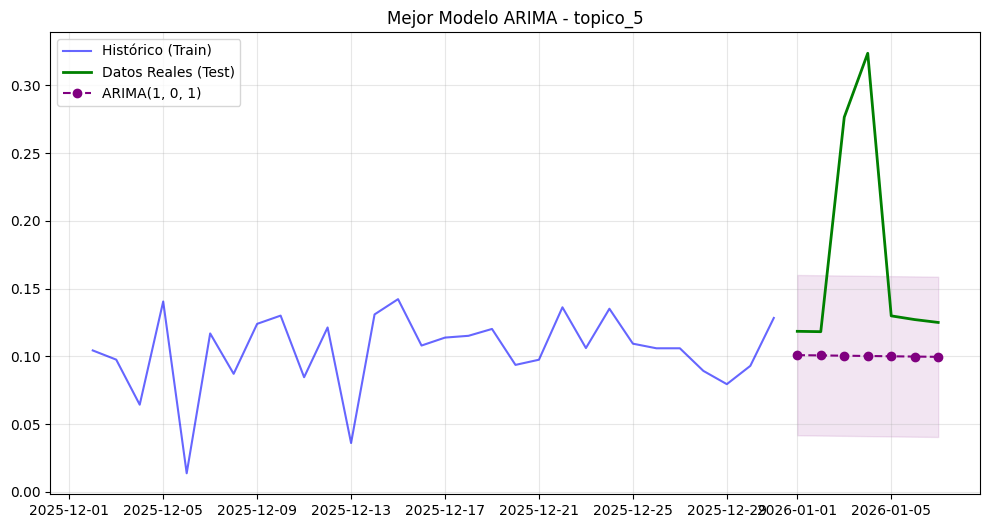


--- Analizando topico_6 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -310.56 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


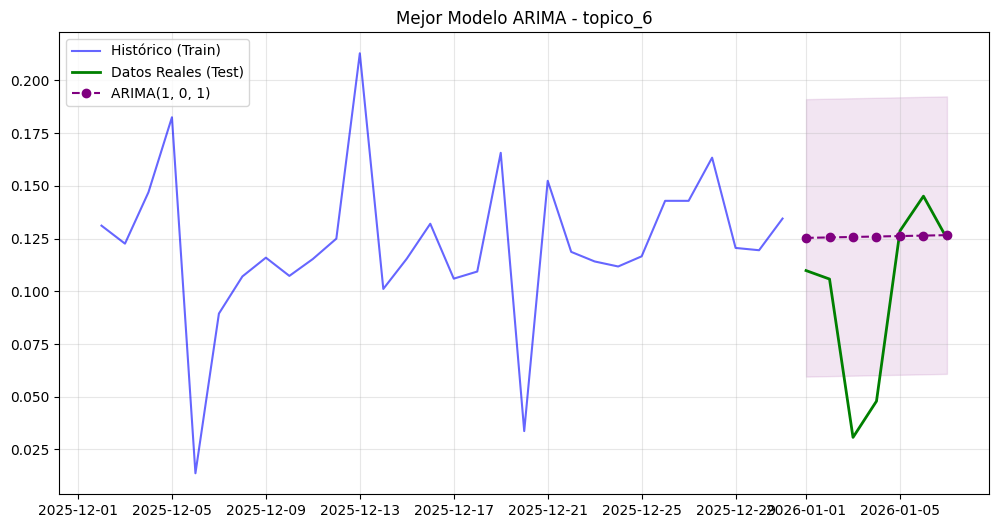


--- Analizando topico_7 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -278.82 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


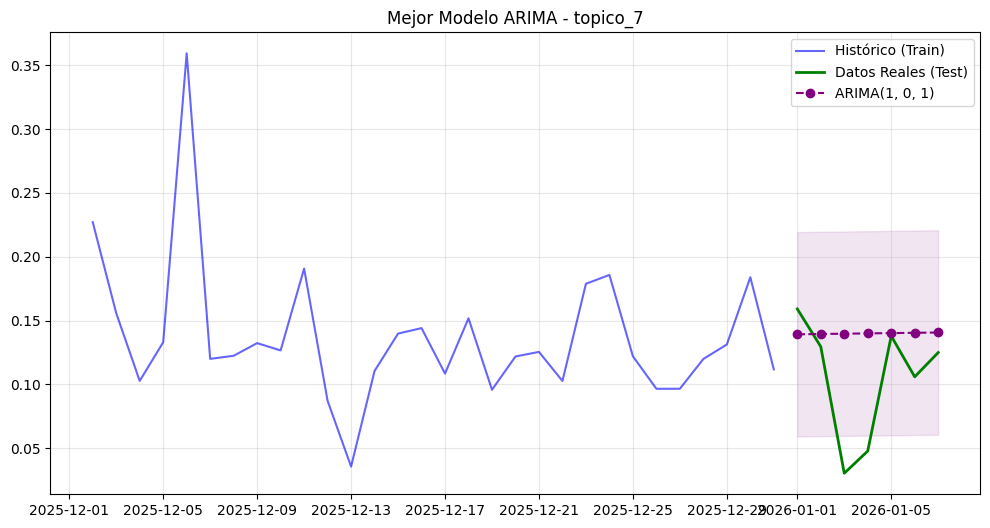

In [16]:
topicos_especiales = ['topico_4', 'topico_1', 'topico_3']
topicos_ruido = [c for c in df_series_temporales.columns if c not in topicos_especiales]

for nombre_topico in topicos_ruido:
    series = df_series_temporales[nombre_topico]
    train = series[:-future_days]
    test = series[-future_days:]
    
    print(f"\n--- Analizando {nombre_topico} ---")
    # Grid Search con d=0, D=0, s=0 (Modelo ARIMA simple)
    best_model, order, _ = grid_search_sarima(train, d=0, D=0, s=0, seasonal=False)
    
    forecast = best_model.get_forecast(steps=future_days)
    pred_mean = forecast.predicted_mean
    pred_ci = forecast.conf_int()
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index[-30:], train.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
    plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=2)
    plt.plot(pred_mean.index, pred_mean, label=f'ARIMA{order}', color='purple', marker='o', linestyle='--')
    plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='purple', alpha=0.1)
    plt.title(f'Mejor Modelo ARIMA - {nombre_topico}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Análisis SARIMA

#### Tópico 4
El modelo SARIMA seleccionado `(1, 1, 1)x(0, 1, 0, 7)` arroja resultados muy similares a los obtenidos previamente con el suavizado exponencial. Aunque el modelo identifica la periodicidad y la dirección de los cambios, **falla sistemáticamente en capturar la magnitud de la volatilidad**, como sucedía con el Holt-Winters. La predicción incapaz de alcanzar los picos extremos de la serie real. Esto evidencia que la complejidad adicional del modelo SARIMA no aporta una ventaja frente al suavizado exponencial en nuestro caso, ya que el componente de ruido  es tan dominante que limita la precisión de cualquier modelo.

#### Tópicos 1 y 3
De manera análoga, los modelos SARIMA para los Tópicos 1 y 3 muestran las mismas limitaciones que sus contrapartes de suavizado, solo se detecta una pequeña mejora en el tópico 1. Capturan el ciclo base, pero se ven desbordados por la variabilidad de la serie.

A pesar de los picos exógenos observados (noviembre/diciembre), hemos decidido no utilizar modelos SARIMAX, ya que estos eventos puntuales (campaña navideña y Black Friday) introducen unos valores que no responden con la dinámica interna de la serie. Podemos respaldar que la dificultad de predicción no es un fallo en los modelos, sino una característica intrínseca de series que no se puede modelar ya que están afectadas por eventos de alto impacto.


#### SARIMAX para el tópico 4

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Lista de columnas que representan los sectores (tú defines esta lista)
sectores = [i for i in df.columns if i not in columnas_excluir and "topico" not in i and "sentimiento" not in i]
print(sectores)

# Función de agrupación (como la que ya usas)
def agrupar(df, columna, freq="D"):
    return df.groupby(pd.Grouper(key="timestamp", freq=freq))[columna].mean()

# Construir X con las series agrupadas
X = pd.DataFrame()

for sector in sectores:
    series_diaria = agrupar(df, sector, freq="D")
    X[sector] = series_diaria

# Aseguramos que el índice temporal esté alineado
X = X.fillna(0)


model = SARIMAX(
    endog=df_series_temporales["topico_4"],
    exog=X,                   # variables exógenas 
    order=(1, 1, 1),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())


['Hostelería y Turismo', 'Sanitario y Salud', 'Educación y Formación', 'Tecnología y Telecomunicaciones', 'Construcción e Inmobiliaria', 'Industria y Manufactura', 'Comercio y Ventas', 'Logística y Transporte', 'Administración y Finanzas', 'Cultura, Arte y Ocio']
                                     SARIMAX Results                                      
Dep. Variable:                           topico_4   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 7)   Log Likelihood                 158.817
Date:                            Thu, 04 Dec 2025   AIC                           -291.635
Time:                                    14:33:31   BIC                           -260.347
Sample:                                10-10-2025   HQIC                          -279.073
                                     - 01-07-2026                                         
Covariance Type:                              opg                                         
        

In [18]:
model = SARIMAX(
    endog=df_series_temporales["topico_1"],
    exog=X,                   # variables exógenas 
    order=(2, 0, 0),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          topico_1   No. Observations:                   90
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 7)   Log Likelihood                 163.004
Date:                           Thu, 04 Dec 2025   AIC                           -300.008
Time:                                   14:33:32   BIC                           -268.563
Sample:                               10-10-2025   HQIC                          -287.375
                                    - 01-07-2026                                         
Covariance Type:                             opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo                0.3175      0.216      1.470      0.142     

In [19]:
model = SARIMAX(
    endog=df_series_temporales["topico_3"],
    exog=X,                   # variables exógenas 
    order=(1, 0, 0),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          topico_3   No. Observations:                   90
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 7)   Log Likelihood                 109.164
Date:                           Thu, 04 Dec 2025   AIC                           -194.328
Time:                                   14:33:32   BIC                           -165.302
Sample:                               10-10-2025   HQIC                          -182.667
                                    - 01-07-2026                                         
Covariance Type:                             opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo                0.1285      0.649      0.198      0.843     

In [21]:
model = SARIMAX(
    endog=df_series_temporales["topico_2"],
    exog=X,                   # variables exógenas 
    order=(2, 0, 1),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           topico_2   No. Observations:                   90
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 7)   Log Likelihood                 127.572
Date:                            Thu, 04 Dec 2025   AIC                           -227.145
Time:                                    14:39:38   BIC                           -193.281
Sample:                                10-10-2025   HQIC                          -213.540
                                     - 01-07-2026                                         
Covariance Type:                              opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo               -0.1249      0.498     -0.251      0.

In [22]:
model = SARIMAX(
    endog=df_series_temporales["topico_6"],
    exog=X,                   # variables exógenas 
    order=(1, 0, 1),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           topico_6   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 7)   Log Likelihood                 150.494
Date:                            jue, 04 dic 2025   AIC                           -274.987
Time:                                    14:46:05   BIC                           -243.542
Sample:                                10-10-2025   HQIC                          -262.354
                                     - 01-07-2026                                         
Covariance Type:                              opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo                0.0752      0.325      0.232      0.